## Homework 3: Convolutional Neural Network

Author: Cao Yanfei

Requirements: build a convolutional neural network for image classification, possibly with some advanced training tips.

Three levels here:
**Easy**: Build a simple convolutional neural network as the baseline.
**Medium**: Design a better architecture or adopt **different data augmentations** to improve the performance.
**Hard**: Utilize provided unlabled data to obtain better results.

### About the Dataset

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data. Please do not access the original fully-labeled training data or testing labels.

Also, the modified dataset is for this course only, and any further distribution or commercial use is forbidden.

In [1]:
# Download the dataset
# You may choose where to download the data.

# Google drive
# !gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Dropbox
# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# MEGA
# !sudo apt install megatools
# !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# Unzip the dataset
# !unzip -q food-11.zip

### Import Packages

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [2]:
# import necessary packages
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# 'ConcatDataset' and 'Subset' are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

D:\software\Anaconda3\installation\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset, Data Loader and Transforms

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our **data are stored in folders by class labels**, we can directly apply `torchvision.datasets.DataFolder` for wrapping data without much effort.

Please refer to [Pytorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_transforms1 = transforms.Compose([
    # Resize the image into a fixed shape (height=width=128)
    transforms.Resize((128, 128)),  
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# You may add some transforms here for data augmentation.
# TODO.......................................................
train_transforms2 = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomPerspective(p=0.5)
    # Performs a random perspective transformation of the given image with a given probability.
    transforms.RandomPerspective(p=1),
    transforms.ToTensor(),
])

train_transforms3 = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomRotation(degrees)
    # Rotate the image by angle.
    transforms.RandomRotation((0, 180)),
    transforms.ToTensor(),
])

train_transforms4 = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomCrop(size)
    # Crop the given image at a random location and enlargerd to a given size.
    transforms.RandomCrop((128, 128)),
    transforms.ToTensor(),
])

train_transforms5 = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomHorizontalFlip(p=0.5)
    # Horizontally flip the given image randomly with a given probability.
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# We do not need augmentation in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
BATCH_SIZE = 128

# Construct datasets
# The argument 'loader' tells how torchvision reads the data.
# Concatenate all dataset obtained from data augmentation to form a final train_set.
# TODO..................................................................
train_set1 = DatasetFolder('./dataset/food-11/training/labeled', loader=lambda x: Image.open(x), extensions='jpg', transform=train_transforms1)
train_set2 = DatasetFolder('./dataset/food-11/training/labeled', loader=lambda x: Image.open(x), extensions='jpg', transform=train_transforms2)
train_set3 = DatasetFolder('./dataset/food-11/training/labeled', loader=lambda x: Image.open(x), extensions='jpg', transform=train_transforms3)
train_set4 = DatasetFolder('./dataset/food-11/training/labeled', loader=lambda x: Image.open(x), extensions='jpg', transform=train_transforms4)
train_set5 = DatasetFolder('./dataset/food-11/training/labeled', loader=lambda x: Image.open(x), extensions='jpg', transform=train_transforms5)

train_set = ConcatDataset([train_set1, train_set2, train_set3, train_set4, train_set5])
valid_set = DatasetFolder('./dataset/food-11/validation', loader=lambda x: Image.open(x), extensions='jpg', transform=test_transforms)
unlabeled_set = DatasetFolder('./dataset/food-11/training/unlabeled', loader=lambda x: Image.open(x), extensions='jpg', transform=train_transforms1)
test_set = DatasetFolder('./dataset/food-11/testing', loader=lambda x: Image.open(x), extensions='jpg', transform=test_transforms)

# Construct data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

## Model

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image(RGB), the input channels of the network must be three. In each convolutional layer, typically the **channels of inputs grow**, while the **height and width shrink** (or remain unchanged, according to some **hyperparameters like stride and padding**).

Before fed into fully-connected layers, the feature map must be **flattened** into a single one-dimensional vector(for each image). These features are then transformed by the fully-connected layers, and finally, we obtain the 'logits' for each class.

## Warning -- You must know

You are free to modify the model architecture here for further improvement. However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pretrained weights. Using such pre-trained models is considered cheating and therefore you will be punished. Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=False)  -> This is fine.
model = torchvision.models.resnet18(pretrained=True)  -> This is not allowed.

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        
        # input image size: [3, 128, 128]
#         self.CNN_layers = nn.Sequential(
#             nn.Conv2d(3, 64, 3, 1, 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
            
#             nn.Conv2d(64, 128, 3, 1, 1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
            
#             nn.Conv2d(128, 256, 3, 1, 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(4, 4, 0),
#         )
        
#         self.FCN_layers = nn.Sequential(
#             nn.Linear(256 * 8 * 8, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 11),
#         )

        # Construct your own network architecture
        # TODO.......................................................................
        # This network is based on AlexNet
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=6, stride=2, padding=2),    # -> [64, 63, 63]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                   # -> [64, 31, 31]
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),  # -> [192, 31, 31]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                   # -> [192, 15, 15]
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),           # -> [384, 15, 15]
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),           # -> [256, 15, 15]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                   # -> [256, 7, 7]
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(256 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 11)
        )
        
        
    def forward(self, x):
        # input(x): [BATCH_SIZE, 3, 128, 128]
        # output: [BATCBATCH_SIZE, 11]

        # Extracted features by convolutional layers.
        # x = self.CNN_layers(x)
        x = self.features(x)

        # Extracted features map must be flatten before going to fully-connected layer.
        # x = x.flatten(1)
        x = torch.flatten(x, 1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        # x = self.FCN_layers(x)
        x = self.classifier(x)

        return x

### Training

You can finish supervised learning by simply running the provided code without any modification.

The function `get_pseudo_labels` is used for semi-supervised learning. It is expected to get better performance if you use unlabeled data for semi-supervised learning. However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to some related videos.

Again, please notice that utilizing external data (or pre-trained model) for training is prohibited.

In [6]:
# Construct extra dataset for semi-supervised learning.
def get_pseudo_labels(dataset, model, threshold=0.65):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Make sure the model is in eval mode.
    model.eval()
    
    # Define softmax function
    softmax = nn.Softmax(dim=-1)
    relabels = torch.as_tensor([]).to(device)
    
    # Iterate over the dataset by batches.
    for batch in tqdm(data_loader):
        img, _ = batch
        
        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))
        
        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)
        
        # Filter the data and construct a new dataset.
        # TODO...................................................................
        maxpred, pseudo_labels = torch.max(probs, dim=1)      # torch.max(input, dim=1) return maximun in each row，and its index（row index of the maximum in this row）
        # Highlight the label with -1 if p fails to reach a certain threshold
        pseudo_labels[maxpred < threshold] = -1
        # Obtain all pseudo labels of data from dataset
        relabels = torch.cat((relabels, pseudo_labels), 0)    # torch.cat() like 'append' func for common iterators
        
    # Update dataset label
    dataset.targets = relabels
    # pick out usable pseudo labels
    select_data_index = relabels > -1
    select_data_index = [i for i in range(len(select_data_index)) if select_data_index[i] == True]    # list comprehensions
    # pick out remnant unusable pseudo labels
    remainder_data_index = relabels == -1
    remainder_data_index = [i for i in range(len(remainder_data_index)) if remainder_data_index[i] == True]
    # Construct filtered dataset with a high enough confidence
    result_dataset = Subset(dataset, select_data_index)
    
    # Turn off the eval mode.
    model.train()
    return result_dataset, remainder_data_index

In [7]:
# 'cuda' ony when GPUs are available.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0003, weight_decay=1e-5)

# The number of training epochs
# N_EPOCHS = 80
N_EPOCHS = 25

# Whether to do semi-supervised learning.
do_semi = False

loss_record = {'train': [], 'validate': []}
acc_record = {'train': [], 'validate': []}

for epoch in range(N_EPOCHS):
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.   
    # Then, you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi:
        # Obtain pseudo-labels for unlabeled data using trained model.
        pseudo_set, remainder_data_index = get_pseudo_labels(unlabeled_set, model, threshold=0.8)
        # update unlabeled_set
        unlabeled_set = Subset(unlabeled_set, remainder_data_index)
        print(f'[Train | {epoch + 1:03d}/{N_EPOCHS:03d}] Length of unlabeled_set:{len(unlabeled_set):03d}')
        
        # Construct a new dataset and a data loader for training
        # This is used in semi-supervised learning only.
        # Construct the new train_set
        train_set = ConcatDataset([train_set, pseudo_set])
        print(f'[Train | {epoch + 1:03d}/{N_EPOCHS:03d}] Length of new train_set:{len(train_set):03d}')
        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

    # -------------------------------------------------Training-------------------------------------------------------
    # Make sure the model is in training mode before training.
    model.train()
    
    # These are used to record information in training.
    training_loss = []
    training_acc = []
    
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))
        
        # Calculate the cross-entropy loss.
        # We do not need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        
        # Compute the gradients for parameters.
        loss.backward()
        
        # Clip the gradient norms for stable training.
        # nn.utils.clip_grad_norm_只解决梯度爆炸问题，不解决梯度消失问题
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Computer the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        
        # Record the loss and accuracy.
        training_loss.append(loss.item())
        training_acc.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    training_loss = sum(training_loss) / len(training_loss)
    training_acc = sum(training_acc) / len(training_acc)
    
    loss_record['train'].append(training_loss)
    acc_record['train'].append(training_acc)
    
    # Print the information
    print(f'[Training | {epoch + 1:03d}/{N_EPOCHS:03d}] loss = {training_loss:.5f}, acc = {training_acc:.5f}')
    
    # -------------------------------------------------Validation-------------------------------------------------------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    validation_loss = []
    validation_acc = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        # A batch consists of image data and coresponding labels.
        imgs, labels = batch
        
        # We do not need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
        
        # We can still compute the loss but not the gradient.
        loss = criterion(logits, labels.to(device))
        
        # Compuete the accuracy for current batch
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        
        # Record the loss and accuracy.
        validation_loss.append(loss.item())
        validation_acc.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    validation_loss = sum(validation_loss) / len(validation_loss)
    validation_acc = sum(validation_acc) / len(validation_acc)
    
    loss_record['validate'].append(validation_loss)
    acc_record['validate'].append(validation_acc)

    # Print the information.
    print(f'[Validation | {epoch + 1:03d}/{N_EPOCHS:03d}] loss = {validation_loss:.5f}, acc = {validation_acc:.5f}')
    
    # update do_semi strategy at the end of current epoch
    # Suggest that it might get better via semi-supervised learning once the validation accuracy reaches higher (over 0.7) after training.
    if validation_acc > 0.6:
        do_semi = True
    else:
        do_semi = False

100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [11:26<00:00,  5.67s/it]


[Training | 001/025] loss = 2.09690, acc = 0.25817


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.43s/it]


[Validation | 001/025] loss = 2.31315, acc = 0.22057


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [11:22<00:00,  5.64s/it]


[Training | 002/025] loss = 1.66737, acc = 0.41569


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.61s/it]


[Validation | 002/025] loss = 1.66061, acc = 0.42760


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [11:18<00:00,  5.61s/it]


[Training | 003/025] loss = 1.44598, acc = 0.49535


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]


[Validation | 003/025] loss = 1.95330, acc = 0.36745


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [11:34<00:00,  5.74s/it]


[Training | 004/025] loss = 1.23899, acc = 0.57122


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.88s/it]


[Validation | 004/025] loss = 1.62063, acc = 0.44974


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [12:09<00:00,  6.03s/it]


[Training | 005/025] loss = 1.09538, acc = 0.62226


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.70s/it]


[Validation | 005/025] loss = 1.37251, acc = 0.52292


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [11:47<00:00,  5.84s/it]


[Training | 006/025] loss = 0.96278, acc = 0.67149


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.68s/it]


[Validation | 006/025] loss = 1.75116, acc = 0.50625


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [10:11<00:00,  5.05s/it]


[Training | 007/025] loss = 0.84419, acc = 0.70996


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.41s/it]


[Validation | 007/025] loss = 1.50335, acc = 0.53047


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [09:23<00:00,  4.66s/it]


[Training | 008/025] loss = 0.74027, acc = 0.75523


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.06s/it]


[Validation | 008/025] loss = 1.61474, acc = 0.53125


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [09:21<00:00,  4.64s/it]


[Training | 009/025] loss = 0.64765, acc = 0.78036


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]


[Validation | 009/025] loss = 1.71634, acc = 0.49609


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [11:15<00:00,  5.58s/it]


[Training | 010/025] loss = 0.57793, acc = 0.80917


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.29s/it]


[Validation | 010/025] loss = 1.40948, acc = 0.56927


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [10:52<00:00,  5.40s/it]


[Training | 011/025] loss = 0.50808, acc = 0.83266


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.15s/it]


[Validation | 011/025] loss = 1.30941, acc = 0.61198


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [02:07<00:00,  2.36s/it]


[Train | 012/025] Length of unlabeled_set:3483
[Train | 012/025] Length of new train_set:18703


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [12:22<00:00,  5.05s/it]


[Training | 012/025] loss = 1.11081, acc = 0.65866


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.07s/it]


[Validation | 012/025] loss = 1.86249, acc = 0.38359


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [11:30<00:00,  4.70s/it]


[Training | 013/025] loss = 0.83600, acc = 0.70083


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.29s/it]


[Validation | 013/025] loss = 1.82243, acc = 0.39427


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [11:31<00:00,  4.70s/it]


[Training | 014/025] loss = 0.71143, acc = 0.74638


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]


[Validation | 014/025] loss = 1.59725, acc = 0.50313


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [11:41<00:00,  4.77s/it]


[Training | 015/025] loss = 0.61664, acc = 0.78137


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]


[Validation | 015/025] loss = 1.60919, acc = 0.51328


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [11:26<00:00,  4.67s/it]


[Training | 016/025] loss = 0.57144, acc = 0.79137


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.11s/it]


[Validation | 016/025] loss = 1.91378, acc = 0.39062


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [11:02<00:00,  4.51s/it]


[Training | 017/025] loss = 0.50890, acc = 0.82195


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.04s/it]


[Validation | 017/025] loss = 2.12671, acc = 0.38776


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [11:01<00:00,  4.50s/it]


[Training | 018/025] loss = 0.45049, acc = 0.83947


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.01s/it]


[Validation | 018/025] loss = 1.99608, acc = 0.43854


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [10:53<00:00,  4.45s/it]


[Training | 019/025] loss = 0.41542, acc = 0.85533


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.03s/it]


[Validation | 019/025] loss = 1.84403, acc = 0.44089


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [10:51<00:00,  4.43s/it]


[Training | 020/025] loss = 0.38369, acc = 0.86577


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.06s/it]


[Validation | 020/025] loss = 2.01673, acc = 0.41719


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [10:53<00:00,  4.45s/it]


[Training | 021/025] loss = 0.36060, acc = 0.87646


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.03s/it]


[Validation | 021/025] loss = 1.92784, acc = 0.40990


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [10:54<00:00,  4.45s/it]


[Training | 022/025] loss = 0.33797, acc = 0.88650


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.01s/it]


[Validation | 022/025] loss = 2.88228, acc = 0.31458


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [10:55<00:00,  4.46s/it]


[Training | 023/025] loss = 0.31271, acc = 0.89514


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.03s/it]


[Validation | 023/025] loss = 2.20901, acc = 0.39974


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [11:03<00:00,  4.51s/it]


[Training | 024/025] loss = 0.28285, acc = 0.90495


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.07s/it]


[Validation | 024/025] loss = 2.33234, acc = 0.41458


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [10:57<00:00,  4.47s/it]


[Training | 025/025] loss = 0.26964, acc = 0.90736


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.06s/it]

[Validation | 025/025] loss = 2.76603, acc = 0.34818


In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_loss_curve(loss_record, title=''):
    '''
    Plot learning loss curve (training and validation loss).
    '''
    total_steps = len(loss_record['train'])
    # each epoch
    x = np.arange(total_steps)
   
    figure(figsize=(10, 8))
    # T10调色盘适用于离散分类，颜色名称以'tab:'为前缀
    plt.plot(x, loss_record['train'], c='tab:red', label='training')
    plt.plot(x, loss_record['validate'], c='tab:cyan', label='validation')
    plt.xlim(-2, 26)
    plt.ylim(0., 5.)
    plt.xticks(np.arange(0, 26, 5))
    plt.yticks(np.arange(0., 6., 1))
    plt.xlabel('Training step/Epoch')
    plt.ylabel('CrossEntropy loss')
    plt.title('Learning loss curve of {}'.format(title))
    plt.legend()
    plt.show()
    
def plot_acc_curve(acc_record, title=''):
    '''
    Plot learning accuracy curve (training and validation accuracy).
    '''
    total_steps = len(acc_record['train'])
    # each epoch
    x = np.arange(total_steps)
   
    figure(figsize=(10, 8))
    # T10调色盘适用于离散分类，颜色名称以'tab:'为前缀
    plt.plot(x, acc_record['train'], c='tab:red', label='training')
    plt.plot(x, acc_record['validate'], c='tab:cyan', label='validation')
    plt.xlim(-2, 26)
    plt.ylim(0., 1.2)
    plt.xticks(np.arange(0, 26, 5))
    plt.yticks(np.arange(0., 1.2, 0.2))
    plt.xlabel('Training step/Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning accuracy curve of {}'.format(title))
    plt.legend()
    plt.show() 

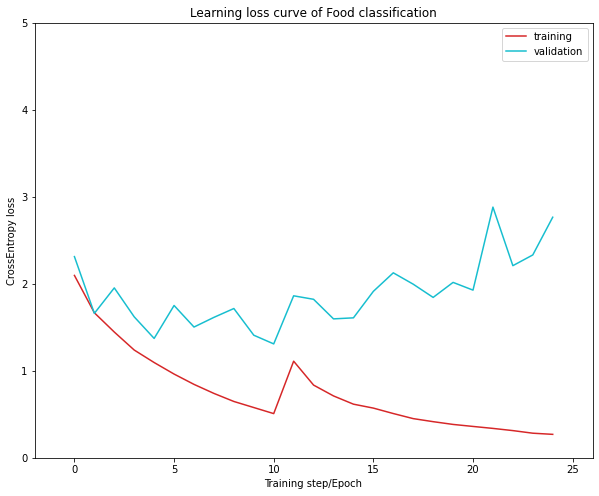

In [13]:
# Show loss variation on training set and validation set during training.
plot_loss_curve(loss_record, title='Food classification')

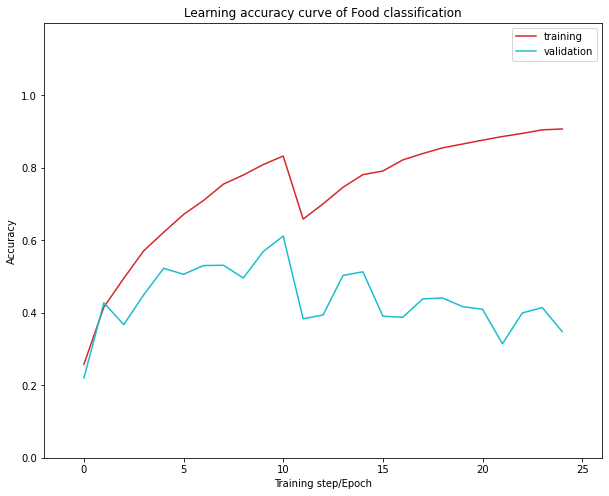

In [14]:
# Show accuracy variation on training set and validation set during training.
plot_acc_curve(acc_record, title='Food classification')

### Testing

For instance, we need to make sure the model is in eval mode, and the order of the dataset should NOT be shuffled ('shuffle=False' in test_loader).

Last but not least, do not forget to save the predictions into a single CSV file. The format of CSV file should follow the rules mentioned in the slides.

### WARNING -- Keep in Mind

Cheating includes but not limited to:

1. Using testing labels
2. Submitting results to previous Kaggle competitions
3. Sharing predictions with others
4. Copying codes from any creatures on Earth

Any violations bring you punishments from getting a discount on the final grade to failing the course.

It is your responsibility to check whether your code violates the rules. When citing codes from the Internet, you should know what these codes exactly do. You will **NOT** be tolerated if you break the rule and claim you do not know these codes do.

In [15]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initalize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable 'labels' is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch
    
    # We do not need gradient in testing, and we do not even have labels to compute loss.
    # Using torch.no_grad() to accelerate the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:57<00:00,  2.13s/it]


In [17]:
# Save predictions into the file.
with open('prediction.csv', 'w') as fd:
    # The first row must be 'Id, Category'
    fd.write('Id,Category\n')
    
    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        fd.write(f'{i}, {pred}\n')

## Reference

Original source: https://github.com/ga642381/ML2021-Spring/blob/main/HW03/HW03.ipynb